In [ ]:
!pip install roboflow

In [1]:
from roboflow import Roboflow
import os

rf = Roboflow(api_key=os.environ["ROBOFLOW_TOKEN"])
project = rf.workspace("thesis-kztn8").project("littering-whlsk")
version = project.version(8)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Littering--8 in yolov11:: 100%|███████| 34812/34812 [07:36<00:00, 76.29it/s]


In [1]:
import os
SCRIPT_DIR = os.path.abspath("")

## Processing sequential frames

In [2]:
dataset_dir = os.path.join(SCRIPT_DIR, 'kkpm.v1-raw.yolov11')

In [3]:
import pickle 

pkl_file = os.path.join(dataset_dir, 'file_sequences.pkl')

with open(pkl_file, 'rb') as f:
  file_sequences = pickle.load(f)

len(file_sequences)

330

In [4]:
video_dir = os.path.join(dataset_dir, 'train/images')
files = [[(os.path.join(video_dir, file), file) for file in sequence] for sequence in file_sequences]

In [20]:
from ultralytics import YOLO
from tqdm import tqdm
from IPython.display import clear_output

# Load a model
model = YOLO(os.path.join(SCRIPT_DIR, "model/TrashDetectorv2/weights/last.pt"))
inf_files = [f for sub in files for f in sub]

# Process results generator
for i in tqdm(range(len(inf_files))):
    file = inf_files[i][0]
    result = model(file)[0]
    boxes = result.boxes 
    masks = result.masks 
    keypoints = result.keypoints 
    probs = result.probs 
    obb = result.obb 
    f = os.path.join(SCRIPT_DIR,f"yolo_res/images_train/{inf_files[i][1]}")
    f_text = os.path.join(SCRIPT_DIR,f"yolo_res/label_train/{inf_files[i][1].replace(".jpg", ".txt")}")
    # print(f)
    result.save(filename=f)
    result.save_txt(txt_file=f_text)
    clear_output()

100%|██████████████████████████| 9899/9899 [38:31<00:00,  4.28it/s]


## Segmenting Region Proposal

In [5]:
from classifier import segment
from tqdm import tqdm
from IPython.display import clear_output

out = os.path.join(SCRIPT_DIR, 'segmented')

for i in tqdm(range(len(file_sequences))):
    for j in range(len(file_sequences[i])):
        label = os.path.join(SCRIPT_DIR, f"yolo_res/label_train/{file_sequences[i][j].replace(".jpg",".txt")}")
        img = os.path.join(SCRIPT_DIR, f"kkpm.v1-raw.yolov11/train/images/{file_sequences[i][j]}")
        segment.crop_humans(img, file_sequences[i][j], label,out)
    clear_output()


100%|████████████████████████████| 330/330 [23:42<00:00,  4.31s/it]


## Extracting Pose Objects

In [1]:
!pip install -q mediapipe

In [2]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from pose_util import pose_util
import csv

out_dir = os.path.join(SCRIPT_DIR, 'landmarks')
segmented_dir = os.path.join(SCRIPT_DIR, 'segmented')

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)


for i in tqdm(range(68, len(file_sequences))):
    sequence = file_sequences[i]
    csv_out = []
    for j, filename in enumerate(sequence):
        inp = os.path.join(segmented_dir, filename.replace(".jpg",""))
        if not os.path.exists(inp):
            continue
        jpg_files = [f for f in os.listdir(inp) if f.lower().endswith('.jpg')]
        for file in jpg_files:
            img_path = os.path.join(inp, file)
            image = mp.Image.create_from_file(img_path)
            detection_result = detector.detect(image)
            person_dict = {'sequence_id': i, 'frame_id': j, 
                           'file_name': filename, 
                           'unproc_person_id': file,
                          }
            pose_landmark_list = detection_result.pose_landmarks
            pose_landmark = pose_landmark_list[0] if len(pose_landmark_list) > 0 else None
            if pose_landmark is None:
                continue
            for k, landmark in enumerate(pose_landmark):
                person_dict[f'landmark_x_{k}'] = landmark.x
                person_dict[f'landmark_y_{k}'] = landmark.y
                person_dict[f'landmark_z_{k}'] = landmark.z
                person_dict[f'visibility_{k}'] = landmark.visibility
                person_dict[f'presence_{k}'] = landmark.presence
            csv_out.append(person_dict)
    csv_file = os.path.join(out_dir, f"sequence_{i}.csv")
    if len(csv_out) > 0:
        with open(csv_file, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=csv_out[0].keys())
            writer.writeheader()
            writer.writerows(csv_out)

I0000 00:00:1733042766.958524  563491 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733042766.993393  601299 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.0.9-0ubuntu0.2), renderer: D3D12 (Intel(R) UHD Graphics)
W0000 00:00:1733042767.056991  601301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733042767.151095  601311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████████████████████▉| 261/262 [37:12<00:08,  8.13s/it]

In [ ]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

i = 272
img_path = "/mnt/c/Adrianov/Projects/trash-detector/segmented/video_6_3_jpg.rf.00e86944269d15c30f60c41164da6afd/1.jpg"
img = cv2.imread(img_path)
# print(img_path)
# print(img)
plt.imshow(img)
plt.show()

I0000 00:00:1733041343.423252  563491 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733041343.452736  596516 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 24.0.9-0ubuntu0.2), renderer: D3D12 (Intel(R) UHD Graphics)
W0000 00:00:1733041343.555365  596519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733041343.835489  596517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detection Result: 33
0.25849971175193787


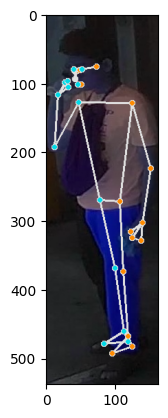

12


In [30]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from pose_util import pose_util

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(img_path)

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

print("Detection Result:", len(detection_result.pose_landmarks[0]))
 
# STEP 5: Process the detection result. In this case, visualize it.
selected_points = [12,14,16,22,18,20,11,13,15,21,19,17]
annotated_image = pose_util.draw_landmarks_on_image(image.numpy_view(), detection_result)
print(detection_result.pose_landmarks[0][0].x)

plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
plt.show()
filtered_result = pose_util.filter_pose(selected_points, detection_result)
print(len(filtered_result.pose_landmarks[0]))

In [5]:
import cv2

i = 713
label = os.path.join(SCRIPT_DIR, f"yolo_res/label/result_{i}.txt")
img = os.path.join(SCRIPT_DIR, f"yolo_res/images/result_{i}.jpg")
overlaps = segment.find_overlapping_regions(label, img)
cropped_regions = segment.crop_regions(img, overlaps, label, i, os.path.join(SCRIPT_DIR,f"masks/imgs/")) 

Cropped image /mnt/c/Adrianov/Projects/trash-detector/yolo_res/images/result_713.jpg and saved result to None
